# **Hyperparameter Optimization of a Neural Network for Fashion-MNIST Classification Using Optuna**

---
## **Overview**
>This script implements a fully connected neural network (FCNN) for classifying the Fashion-MNIST dataset. It utilizes PyTorch for model building and training, and Optuna for hyperparameter optimization. The workflow includes loading and preprocessing the dataset, defining a dataset class for PyTorch, creating a configurable neural network architecture, and optimizing the model using various hyperparameters such as the number of layers, neurons per layer, dropout rate, optimizer type, and learning rate. The objective function is defined to train and evaluate the model, and Optuna is used to search for the best-performing hyperparameters.

---
## **Installing Dependencies:**
- Installs the Optuna library for hyperparameter optimization.

In [12]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00


---
## **Importing Required Libraries:**
- Imports necessary Python libraries including `pandas` for data handling, `matplotlib` for `visualization`, `torch` for deep learning, `sklearn` for data splitting, and `optuna` for hyperparameter tuning.

In [16]:
from zipfile import ZipFile

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import optuna

In [17]:
torch.manual_seed(42)

---
## **Setting Up PyTorch Device:**
- Checks for GPU availability and sets device accordingly.

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

---
## **Extracting and Loading Dataset:**
- Extracts the Fashion-MNIST dataset from a ZIP file.
- Reads the dataset into a Pandas DataFrame and displays the first few rows.

In [19]:
with ZipFile("/content/fashion.zip", "r") as zip_file:
    zip_file.extractall("fashion")

In [20]:
df = pd.read_csv("/content/fashion/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


---
## **Visualizing Sample Images:**
- Plots the first 16 images with their labels for an overview of the dataset.

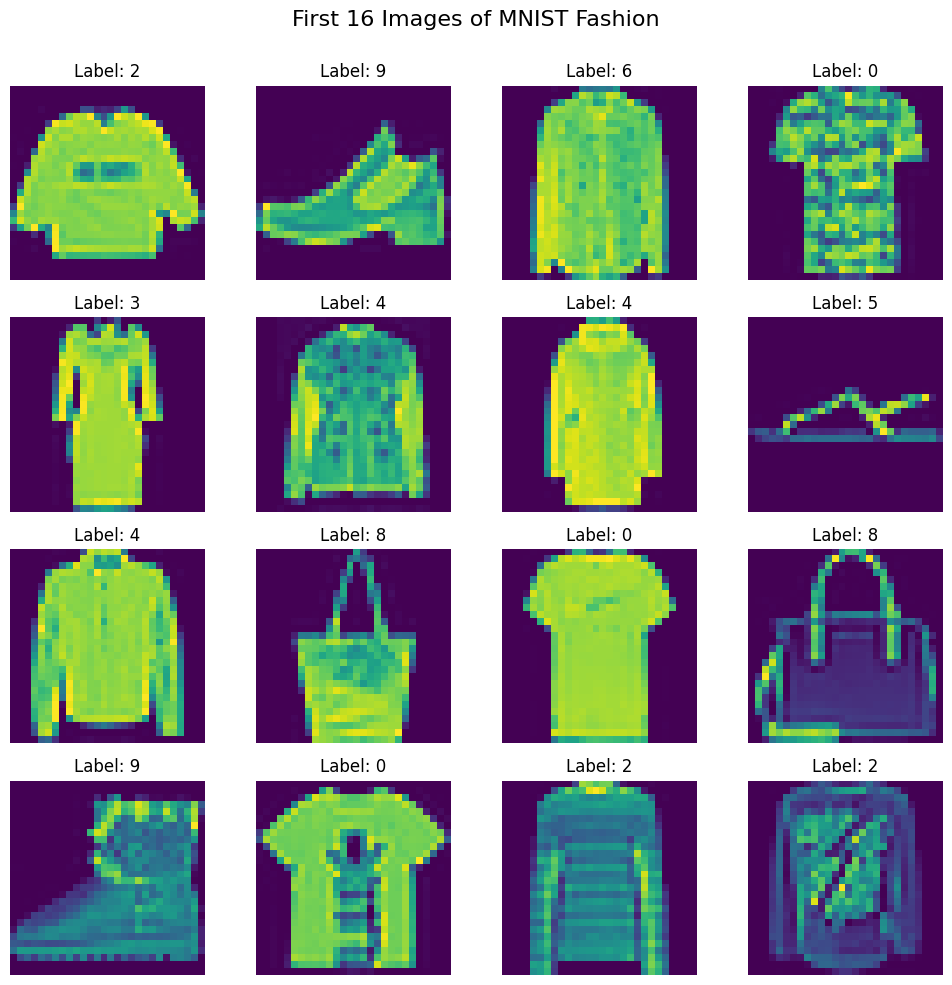

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images of MNIST Fashion\n", fontsize=16)

for i, ax in enumerate(axes.flat):
    ax.imshow(df.iloc[i, 1:].values.reshape(28, 28))
    ax.set_title(f"Label: {df.iloc[i, 0]}")
    ax.axis("off")

plt.tight_layout()
plt.show();

---
## **Preprocessing Data:**
- Splits the dataset into features (`X`) and labels (`y`).
- Divides the data into training and test sets.
- Normalizes pixel values to the range [0, 1] for better model performance.

In [22]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_train = X_train / 255.0
X_test = X_test / 255.0

---
## **Creating a Custom PyTorch Dataset Class:**
- Defines FashionDataset, a PyTorch Dataset class to wrap the training and test data.
- Converts features and labels into PyTorch tensors.

In [25]:
class FashionDataset(Dataset):
  def __init__(self, features, labels):
    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]

In [26]:
train_dataset = FashionDataset(X_train, y_train)
test_dataset = FashionDataset(X_test, y_test)

---
## **Defining the Neural Network Architecture:**
- Implements NeuralNetwork class which constructs a multi-layer perceptron (MLP) with configurable hidden layers, dropout, batch normalization, and ReLU activation.
- The number of hidden layers and neurons per layer are dynamically set during hyperparameter optimization.

In [27]:
class NeuralNetwork(nn.Module):
  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
    super().__init__()

    layers = []

    for i in range(num_hidden_layers):
      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer
    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

---
## **Defining the Objective Function for Optuna Optimization:**
- Specifies the hyperparameters to be optimized using trial.suggest_* methods (e.g., number of hidden layers, learning rate, dropout rate, etc.).
- Configures the data loaders for training and testing.
- Initializes the neural network with trial-selected hyperparameters.
- Trains the model using the specified optimizer and loss function.
- Evaluates the model accuracy on the test set and returns the accuracy as the optimization objective.

In [29]:
def objective(trial):
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  input_dim = X_train.shape[1]
  output_dim = 10

  model = NeuralNetwork(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  criterion = nn.CrossEntropyLoss()

  if optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  for epoch in range(epochs):
    for batch_features, batch_labels in train_loader:
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      optimizer.zero_grad()
      outputs = model(batch_features)
      loss = criterion(outputs, batch_labels)
      loss.backward()
      optimizer.step()

  model.eval()

  total = 0
  correct = 0

  with torch.no_grad():
    for batch_features, batch_labels in test_loader:
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
      outputs = model(batch_features)
      _, predicted = torch.max(outputs, 1)
      total += batch_labels.shape[0]
      correct += (predicted == batch_labels).sum().item()

  accuracy = 100 * correct / total

  return accuracy

---
##Running Hyperparameter Optimization:**
- Creates an Optuna study with a goal to maximize accuracy.
- Runs the optimization for 10 trials to find the best hyperparameters.
- Prints the best accuracy achieved and the corresponding hyperparameters.

In [30]:
study = optuna.create_study(direction="maximize")

[I 2025-01-31 03:26:30,736] A new study created in memory with name: no-name-5538e0f4-13e5-4a23-b1b2-c5b35510a110


In [31]:
study.optimize(objective, n_trials=10)

[I 2025-01-31 03:27:16,198] Trial 0 finished with value: 76.96666666666667 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 16, 'epochs': 40, 'learning_rate': 0.0002184099171899561, 'dropout_rate': 0.1, 'weight_decay': 1.310448486739522e-05, 'batch_size': 128, 'optimizer': 'SGD'}. Best is trial 0 with value: 76.96666666666667.
[I 2025-01-31 03:27:32,592] Trial 1 finished with value: 83.575 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 40, 'epochs': 10, 'learning_rate': 0.004091595672865385, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.0001023277096422653, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 1 with value: 83.575.
[I 2025-01-31 03:28:38,430] Trial 2 finished with value: 69.775 and parameters: {'num_hidden_layers': 5, 'neurons_per_layer': 56, 'epochs': 40, 'learning_rate': 0.024216379853238188, 'dropout_rate': 0.30000000000000004, 'weight_decay': 0.0004939762186810505, 'batch_size': 128, 'optimizer': 'Adam'}. Best is trial 1 with v

In [33]:
print(f"Best Accuracy: {study.best_value:.3f}\n\n")
print(f"Best Parameters:\n{study.best_params}")

Best Accuracy: 88.842


Best Parameters:
{'num_hidden_layers': 2, 'neurons_per_layer': 48, 'epochs': 40, 'learning_rate': 0.0003658144737350925, 'dropout_rate': 0.1, 'weight_decay': 0.00015421355976244985, 'batch_size': 16, 'optimizer': 'Adam'}
